In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [4]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba[:,1])]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [5]:
random_seed = 108
test_size = 0.2

In [7]:
orig_data = pd.read_csv('MASTER STEMI database 2010 - 2019.csv')

In [8]:
cols = [
    'Age',
    'Sex (0 = Male, 1=Female)',
    'Height',
    'Weight',
    'BMI',
    'Hypertension', 
    'Hypercholesterolaemia',
    'Smoking History( 2= current, 1 = ex smoke, 0 = never)', 
    'Diabetes',
    'Family History',
    'Previous stent',
    'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)',
    'TIMI flow pre', 
    'TIMI Flow post',
    'Rentrop Simplified',
    'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)',
    'No. of stent',
    'Length of stent',
    'CTO in remote vessel',
    'Pre-Hospital Arrest',
    'GP IIb/IIIa inhibitor', 
    'Inotrope during case', 
    'Starting HR',
    'Starting SBP',
    'Arrhythmia during case', 
    'IABP/ECMO',
    'Time from onset to angio (Hrs)'
]

orig_data['LVEF FINAL'] = orig_data['LVEF FINAL'].replace([-55,-99],np.NaN)

orig_data["lvef_abnormal"] = [np.NaN if np.isnan(x) else 1 if x < 40 else 0 for x in orig_data['LVEF FINAL']]

predictors = ["lvef_abnormal",'In-Hospital Mortality','ICU admission']

df = orig_data[cols + predictors]

In [9]:
df = df.replace([-55,-99],np.NaN)

for c in df.columns:
    df[c] = df[c].replace('', np.NaN)
    df[c] = df[c].replace('-', np.NaN)
    df[c] = df[c].replace('[a-zA-Z]+', np.NaN).astype(float)
    
df["Height"] = df["Height"].replace(0,np.NaN)
df["Age"] = df["Age"].where(df.Age.between(16, 105)) # remove ages less than 16 and greater than 105

df['Time from onset to angio (Hrs)'] = df['Time from onset to angio (Hrs)'].where(df['Time from onset to angio (Hrs)'] >= 0) 

In [10]:
df["log_length_stent"] = np.log(df['Length of stent'])
df["log_onset_to_angio"] = np.log(df['Time from onset to angio (Hrs)'])
df.drop(['Length of stent','Time from onset to angio (Hrs)'],axis = 1,inplace=True)

In [11]:
df_subset_index = {}
for p in predictors:
    df_subset_index[p] = df.index[df[p].notna()].tolist()

In [12]:
float_col = [
    'Age',
    'Height',
    'Weight',
    'BMI',
    #'Length of stent',
    'log_length_stent',
    'Starting HR',
    'Starting SBP',
    #'Time from onset to angio (Hrs)',
    'log_onset_to_angio',
    'No. of stent'
]
categorical_col = [c for c in df.columns if c not in float_col + predictors]

In [13]:
df_dummy =  pd.get_dummies(
        df,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [14]:
df_dummy.columns
df_dummy_cat_cols = [x for x in df_dummy.columns if x not in float_col + predictors]

In [15]:
from sklearn.model_selection import train_test_split

train,test = {},{}
for p in predictors:
    train[p],test[p]= train_test_split(df_subset_index[p], test_size=test_size, random_state=random_seed)


In [20]:
final_result_df = pd.read_csv("result/final_out.csv")

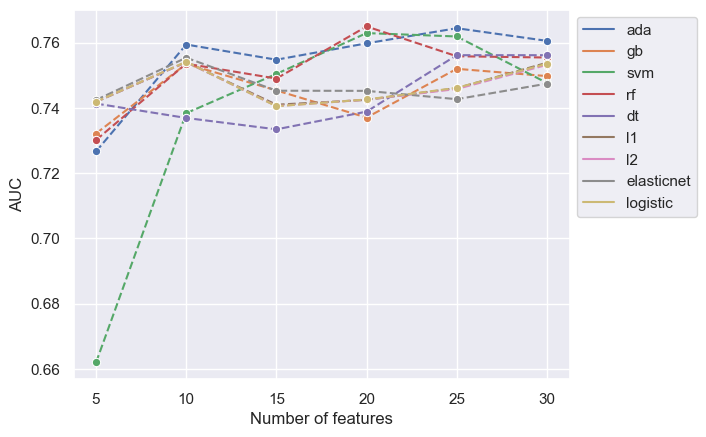

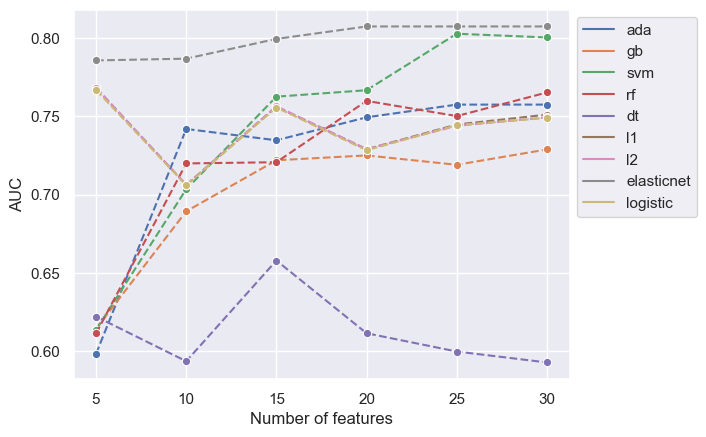

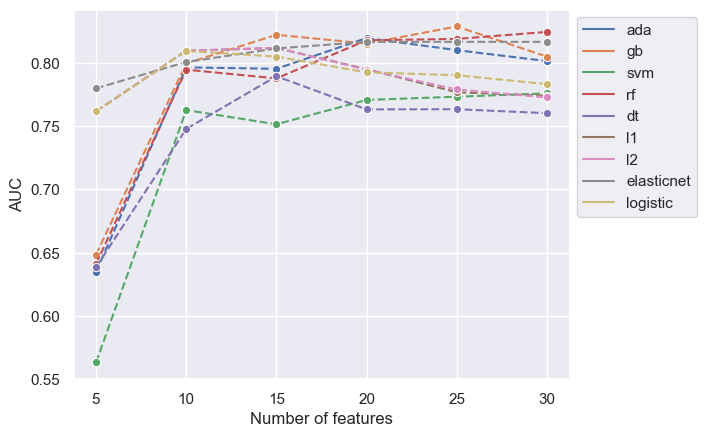

In [44]:
for p in predictors:
    f,ax = plt.subplots()
    #for m in final_result_df["model"].unique():
    df_sub = final_result_df.query("outcome == @p")
    ax = sns.lineplot(df_sub,x = 'n_feature',y='auc',hue='model',ax=ax,marker='o',linestyle ='--')
    ax.set_xlabel('Number of features')
    ax.set_ylabel('AUC')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig("figure/n_feature_plot_" + p +".png",bbox_inches="tight")